<a href="https://colab.research.google.com/github/fgs2/f20aa-2024/blob/main/cw2/bagOfWords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# F20AA Applied Text Analytics: Coursework 2 - Bag of Words

#### Deadline: 11:59pm, Monday 1st April 2024 via Canvas group space

#### Members:
- Francis Sandrino (fgs2)
- Jai Varsani (jv81)
- Ahmed Moussa Abdelfattah (asa30)
- Aamir Nazir (mn2025)

### What is this?
The purpose of this notebook is to serve as a form of parallelization with different Google Colab accounts to speed up experimentation. This notebook will have minimal documentation, only to aid the group members in understanding the code. The proper documentation, results, and discussion for all processing notebooks is included in the [main file](../amazonCW.ipynb).

### What does this specific notebook deal with?
Experimentation with Bag-Of-Words.

### Experiment Parameters
These were chosen based on CW 1 results.
- Representations: binary, count, TF-IDF, freq
- Models to test: Vanilla ANN

In [1]:
# This is so I don't have to keep uploading on Colab.

import os
import requests
from requests.auth import HTTPBasicAuth

def downloadFileFromRepo(username, repository, branch, filepath, token):
    # Construct the URL to download the file from GitHub
    url = f"https://raw.githubusercontent.com/{username}/{repository}/{branch}/{filepath}"

    # Send a GET request to download the file
    response = requests.get(url, auth=HTTPBasicAuth(username, token))

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract the file name from the URL
        fileName = filepath.split('/')[-1]

        # Create the 'data' directory if it doesn't exist
        if not os.path.exists('data'):
            os.makedirs('data')

        # Define the file path within the 'data' directory
        localFilepath = os.path.join('data', fileName)

        # Write the file content to a local file
        with open(localFilepath, 'wb') as f:
            f.write(response.content)
        print(f"File '{fileName}' downloaded successfully.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

username = ""
repository = ""
branch = ""
path_to_file = ""
repoToken = ""
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/trainStemmed.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/testLemmatized.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/testStemmed.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/lemmaTokenizer.json"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/stemTokenizer.json"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

File 'trainLemmatized.csv' downloaded successfully.
File 'trainStemmed.csv' downloaded successfully.
File 'testLemmatized.csv' downloaded successfully.
File 'testStemmed.csv' downloaded successfully.
File 'lemmaTokenizer.json' downloaded successfully.
File 'stemTokenizer.json' downloaded successfully.


In [2]:
!pip install --upgrade pip
!pip install tensorflow
!pip install pyyaml h5py

import tensorflow as tf
import nltk
import numpy as np
import pandas as pd

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

nltk.download('wordnet')
nltk.download('punkt')

seed = 50

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
dataset = pd.read_csv("data/trainLemmatized.csv")
training, testing = train_test_split(dataset, stratify = dataset['labels'], test_size=0.1, random_state=42)
training.to_csv("data/trainLemmatizedTr.csv", index = False)
testing.to_csv("data/trainLemmatizedTe.csv", index = False)

trainBatchSize = 256

dataset = tf.data.experimental.make_csv_dataset("data/trainLemmatized.csv",
                                                batch_size = trainBatchSize,
                                                select_columns = ["data", "labels"],
                                                label_name = "labels",
                                                num_epochs = 1,
                                                shuffle = True,
                                                shuffle_buffer_size = int(trainBatchSize*1.5))

# datasetTest = tf.data.experimental.make_csv_dataset("data/trainLemmatizedTe.csv",
#                                                 batch_size = trainBatchSize,
#                                                 select_columns = ["data", "labels"],
#                                                 label_name = "labels",
#                                                 num_epochs = 5,
#                                                 shuffle = True,
#                                                 shuffle_buffer_size = int(trainBatchSize*1.5))

# Loading tokenizers from the JSON files
with open("data/lemmaTokenizer.json", "r") as json_file:
    tokenizerJSON = json_file.read()
    lemmaTokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizerJSON)
lemmaVocabSize = len(lemmaTokenizer.word_index)

MAXLENGTH = 1885
print(f"Lemmatized Tokenizer loaded successfully with {lemmaVocabSize} words.")
print(f"Max length for a document: {MAXLENGTH}")

Lemmatized Tokenizer loaded successfully with 77413 words.
Max length for a document: 1885


In [4]:
# Print out the list of available physical devices (e.g., GPUs)
print("Available physical devices:")
print(tf.config.list_physical_devices('GPU'))


Available physical devices:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
%%time

# Iterator to avoid loading the entire dataset
iterator = iter(dataset)
# iteratorTest = iter(datasetTest)
# To keep track of which batch we're operating on
progress = 0
# Folds for cross-validation
kSplits = 10

# For evaluation later

TESTINTERVAL = 1
accuracy = 0
progress = 0
updateAccuracy = 1
maxAccuracy = 0
aveAccuracy = 0
batch_loss = 0
batch_accuracy = 0
losses = []
accuracies = []

model = tf.keras.Sequential([
    Dense(256, activation='relu'),  # Input layer with 64 neurons and ReLU activation
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

try:
  while True:
    # Admin stuff
    progress = progress + 1
    clear_output(wait = True)
    print(f"Batch number: {progress}")
    print(f"Batch loss: {batch_loss}")
    print(f"Batch accuracy: {batch_accuracy}\n")
    # print(f"Next test accuracy update at batch: {updateAccuracy}")
    print(f"Max accuracy: {maxAccuracy}")
    print(f"Latest accuracy: {accuracy}")
    print(f"Average accuracy: {aveAccuracy}")

    # Obtain batch of text as a list
    batch = next(iterator)
    current = batch[0]['data'].numpy().tolist()
    decoded = list(map((lambda x : x.decode()), current))

    # Keep track of labels of each batch
    currentLabels = batch[1].numpy().tolist()

    # Convert to matrix of counts (frequency of word occurrence)
    tokenizedDocs = lemmaTokenizer.texts_to_matrix(decoded, mode = 'count')

    # skf = StratifiedKFold(n_splits = kSplits, shuffle = True, random_state = seed)
    # # 10-fold cross-validation
    # for trainIndex, testIndex in skf.split(xTrain, yTrain):

    #   xTrainFold, xTestFold = xTrain[trainIndex], xTrain[testIndex]
    #   yTrainFold, yTestFold = [yTrain[i] - 1 for i in trainIndex], [yTrain[i] - 1 for i in testIndex]

    #   yTrainEncoded = tf.keras.utils.to_categorical(yTrainFold, num_classes = 5)
    #   yTestEncoded = tf.keras.utils.to_categorical(yTestFold, num_classes = 5)

    #   model.train_on_batch(xTrainFold, yTrainEncoded)

    #   loss, accuracy = model.evaluate(xTestFold, yTestEncoded)
    #   losses.append(loss)
    #   accuracies.append(accuracy)

    currentLabels = [x - 1 for x in currentLabels]
    currentLabels = tf.keras.utils.to_categorical(currentLabels, num_classes = 5)

    xTrain, xTest, yTrain, yTest = train_test_split(tokenizedDocs, currentLabels, test_size=0.15, random_state=42)
    # tokenizedDocs = tf.constant(tokenizedDocs)
    # currentLabels = tf.constant(currentLabels)
    history = model.fit(tokenizedDocs, currentLabels, batch_size = trainBatchSize, validation_data = (xTest, yTest))
    batch_loss = history.history['loss']
    batch_accuracy = history.history['accuracy']
    loss = history.history['val_loss'][0]
    accuracy = history.history['val_accuracy'][0]
    losses.append(loss)
    accuracies.append(accuracy)
    aveAccuracy = (((aveAccuracy * (progress - 1)) + accuracy) / (progress / updateAccuracy))
    if maxAccuracy < accuracy:
        maxAccuracy = accuracy
    # updateAccuracy = updateAccuracy + TESTINTERVAL
except StopIteration:
  print("End of iterator reached.")

# tempLosses = []
# tempAcc = []
# try:
#   while True:
#     batch = next(iteratorTest)
#     current = batch[0]['data'].numpy().tolist()
#     decoded = list(map((lambda x : x.decode()), current))
#     currentLabels = batch[1].numpy().tolist()
#     tokenizedDocs = lemmaTokenizer.texts_to_matrix(decoded, mode = 'count')
#     currentLabels = [x - 1 for x in currentLabels]
#     currentLabels = tf.keras.utils.to_categorical(currentLabels, num_classes = 5)
#     loss, accuracy = model.evaluate(tokenizedDocs, currentLabels, batch_size = 1)
#     tempLosses.append(loss)
#     tempAcc.append(accuracy)
# except StopIteration:
#   print("End of testing.")
# loss = sum(tempLosses) / len(tempLosses)
# accuracy = sum(tempAcc) / len(tempAcc)
# losses.append(loss)
# accuracies.append(accuracy)
# aveAccuracy = (((aveAccuracy * (progress - 1)) + accuracy) / (progress / updateAccuracy))
# if maxAccuracy < accuracy:
#     maxAccuracy = accuracy
# updateAccuracy = updateAccuracy + TESTINTERVAL

Batch number: 1449
Batch loss: [0.2893350124359131]
Batch accuracy: [0.8928571343421936]

Max accuracy: 1.0
Latest accuracy: 1.0
Average accuracy: 0.802858065299237
End of iterator reached.
CPU times: user 8min 35s, sys: 6min, total: 14min 35s
Wall time: 16min 12s


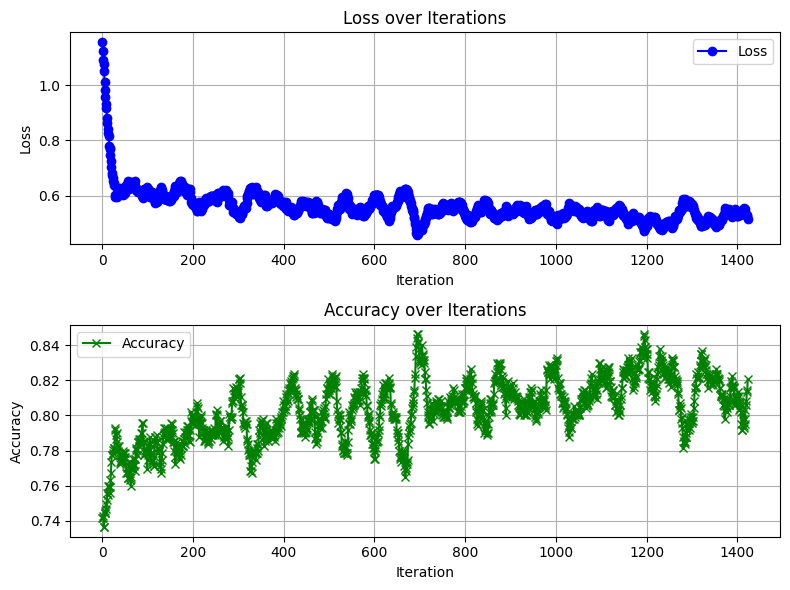

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

def movingAverage(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    smooth = np.convolve(data, weights, 'valid')
    return smooth

# Define window size for smoothing (adjust as needed)
window_size = 25

smoothedL = movingAverage(losses, window_size)
smoothedA = movingAverage(accuracies, window_size)

# Plot losses on the first subplot
axs[0].plot(smoothedL, marker='o', label='Loss', color='blue')  # 'o' for markers at data points
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over Iterations')
axs[0].legend()  # Show legend with labels
axs[0].grid(True)  # Enable grid

# Plot accuracies on the second subplot
axs[1].plot(smoothedA, marker='x', label='Accuracy', color='green')  # 'x' for different markers
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over Iterations')
axs[1].legend()  # Show legend with labels
axs[1].grid(True)  # Enable grid

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
%%time

testBatchSize = 256
dataset = tf.data.experimental.make_csv_dataset("data/testLemmatized.csv",
                                                batch_size = testBatchSize,
                                                select_columns = ["processed"],
                                                num_epochs = 1,
                                                shuffle = False)

iterator = iter(dataset)
preds = []
progress = 0

try:
  while True:

    # Admin stuff
    progress = progress + 1
    clear_output(wait = True)
    print(f"Test batch number: {progress}")

    # Obtain batch of text as a list
    batch = next(iterator)
    current = batch['processed'].numpy().tolist()
    decoded = list(map((lambda x : x.decode()), current))

    # Proper model input format
    tokenizedDocs = lemmaTokenizer.texts_to_matrix(decoded, mode = 'count')

    # Testing against the model
    pred = model.predict(tokenizedDocs)
    truePredict = np.argmax(pred, axis = 1) + 1
    preds.append(truePredict)

except StopIteration:
  print("End of iterator reached.")

concatenated = np.concatenate(preds)
results = pd.DataFrame(concatenated)
results.rename(columns = {0 : 'overall'}, inplace = True)
results.insert(0, 'id', range(len(results)))
results

# results.to_csv(f"LemmaANN{progress}.csv", index = False)
# model.save(f"LemmaANN{progress}.keras")
# loaded_model = tf.keras.saving.load_model('insert-model-name.keras')

Test batch number: 484
End of iterator reached.
CPU times: user 2min 1s, sys: 1min 15s, total: 3min 17s
Wall time: 3min 20s


,id,overall
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5
...,...,...
123617,123617,5
123618,123618,5
123619,123619,5
123620,123620,5


In [8]:
%%time

import matplotlib.pyplot as plt

def movingAverage(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    smooth = np.convolve(data, weights, 'valid')
    return smooth

dataset = tf.data.experimental.make_csv_dataset("data/trainLemmatized.csv",
                                            batch_size = trainBatchSize,
                                            select_columns = ["data", "labels"],
                                            label_name = "labels",
                                            num_epochs = 1,
                                            shuffle = True,
                                            shuffle_buffer_size = int(trainBatchSize*1.5))

# Iterator to avoid loading the entire dataset
iterator = iter(dataset)
# iteratorTest = iter(datasetTest)
# To keep track of which batch we're operating on
progress = 0
window_size = 50

# For evaluation later
TESTINTERVAL = 1
accuracy = 0
progress = 0
updateAccuracy = 1
maxAccuracy = 0
aveAccuracy = 0
batch_loss = 0
batch_accuracy = 0
losses = []
accuracies = []

model = tf.keras.Sequential([
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

try:
  while True:
    # Admin stuff
    progress = progress + 1
    clear_output(wait = True)
    print(f"Batch number: {progress}")
    print(f"Batch loss: {batch_loss}")
    print(f"Batch accuracy: {batch_accuracy}\n")
    print(f"Max accuracy: {maxAccuracy}")
    print(f"Latest accuracy: {accuracy}")
    print(f"Average accuracy: {aveAccuracy}")

    # Obtain batch of text as a list
    batch = next(iterator)
    current = batch[0]['data'].numpy().tolist()
    decoded = list(map((lambda x : x.decode()), current))

    # Keep track of labels of each batch
    currentLabels = batch[1].numpy().tolist()

    # Convert to matrix of counts (frequency of word occurrence)
    tokenizedDocs = lemmaTokenizer.texts_to_matrix(decoded, mode = 'binary')

    currentLabels = [x - 1 for x in currentLabels]
    currentLabels = tf.keras.utils.to_categorical(currentLabels, num_classes = 5)

    xTrain, xTest, yTrain, yTest = train_test_split(tokenizedDocs, currentLabels, test_size=0.15, random_state=42)
    history = model.fit(tokenizedDocs, currentLabels, batch_size = trainBatchSize, validation_data = (xTest, yTest))
    batch_loss = history.history['loss']
    batch_accuracy = history.history['accuracy']
    loss = history.history['val_loss'][0]
    accuracy = history.history['val_accuracy'][0]
    losses.append(loss)
    accuracies.append(accuracy)
    aveAccuracy = (((aveAccuracy * (progress - 1)) + accuracy) / (progress / updateAccuracy))
    if maxAccuracy < accuracy:
        maxAccuracy = accuracy
except StopIteration:
  print("End of iterator reached.")

Batch number: 1449
Batch loss: [0.7313008904457092]
Batch accuracy: [0.75]

Max accuracy: 1.0
Latest accuracy: 1.0
Average accuracy: 0.8020789181576908
End of iterator reached.
CPU times: user 8min 26s, sys: 5min 33s, total: 13min 59s
Wall time: 15min 24s


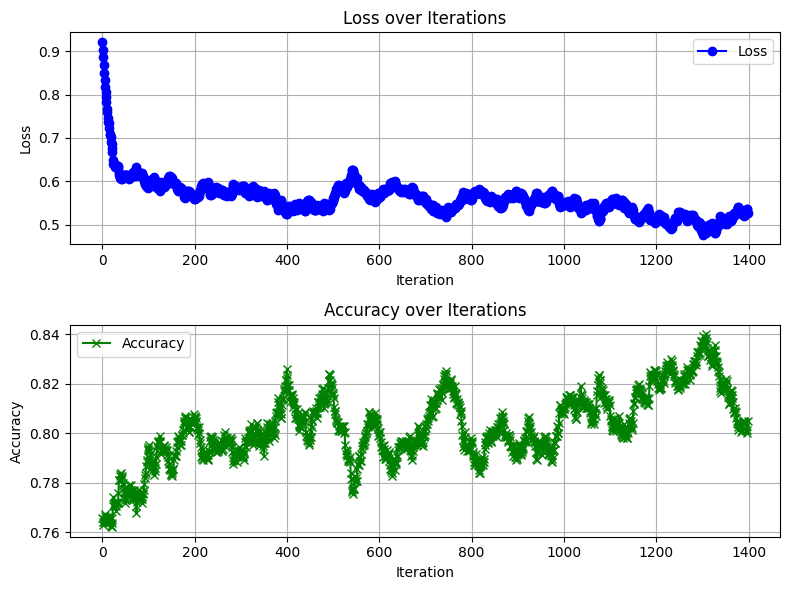

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

smoothedL = movingAverage(losses, window_size)
smoothedA = movingAverage(accuracies, window_size)

# Plot losses on the first subplot
axs[0].plot(smoothedL, marker='o', label='Loss', color='blue')  # 'o' for markers at data points
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over Iterations')
axs[0].legend()  # Show legend with labels
axs[0].grid(True)  # Enable grid

# Plot accuracies on the second subplot
axs[1].plot(smoothedA, marker='x', label='Accuracy', color='green')  # 'x' for different markers
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over Iterations')
axs[1].legend()  # Show legend with labels
axs[1].grid(True)  # Enable grid

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
%%time

import matplotlib.pyplot as plt

def movingAverage(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    smooth = np.convolve(data, weights, 'valid')
    return smooth

dataset = tf.data.experimental.make_csv_dataset("data/trainLemmatized.csv",
                                                batch_size = trainBatchSize,
                                                select_columns = ["data", "labels"],
                                                label_name = "labels",
                                                num_epochs = 1,
                                                shuffle = True,
                                                shuffle_buffer_size = int(trainBatchSize*1.5))

# Iterator to avoid loading the entire dataset
iterator = iter(dataset)
# iteratorTest = iter(datasetTest)
# To keep track of which batch we're operating on
progress = 0
# Folds for cross-validation
kSplits = 10

# For evaluation later
TESTINTERVAL = 1
accuracy = 0
progress = 0
updateAccuracy = 1
maxAccuracy = 0
aveAccuracy = 0
batch_loss = 0
batch_accuracy = 0
losses = []
accuracies = []

model = tf.keras.Sequential([
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

try:
  while True:
    # Admin stuff
    progress = progress + 1
    clear_output(wait = True)
    print(f"Batch number: {progress}")
    print(f"Batch loss: {batch_loss}")
    print(f"Batch accuracy: {batch_accuracy}\n")
    print(f"Max accuracy: {maxAccuracy}")
    print(f"Latest accuracy: {accuracy}")
    print(f"Average accuracy: {aveAccuracy}")

    # Obtain batch of text as a list
    batch = next(iterator)
    current = batch[0]['data'].numpy().tolist()
    decoded = list(map((lambda x : x.decode()), current))

    # Keep track of labels of each batch
    currentLabels = batch[1].numpy().tolist()

    # Convert to matrix of counts (frequency of word occurrence)
    tokenizedDocs = lemmaTokenizer.texts_to_matrix(decoded, mode = 'tfidf')

    currentLabels = [x - 1 for x in currentLabels]
    currentLabels = tf.keras.utils.to_categorical(currentLabels, num_classes = 5)

    xTrain, xTest, yTrain, yTest = train_test_split(tokenizedDocs, currentLabels, test_size=0.15, random_state=42)
    history = model.fit(tokenizedDocs, currentLabels, batch_size = trainBatchSize, validation_data = (xTest, yTest))
    batch_loss = history.history['loss']
    batch_accuracy = history.history['accuracy']
    loss = history.history['val_loss'][0]
    accuracy = history.history['val_accuracy'][0]
    losses.append(loss)
    accuracies.append(accuracy)
    aveAccuracy = (((aveAccuracy * (progress - 1)) + accuracy) / (progress / updateAccuracy))
    if maxAccuracy < accuracy:
        maxAccuracy = accuracy
except StopIteration:
  print("End of iterator reached.")

Batch number: 1449
Batch loss: [0.42330488562583923]
Batch accuracy: [0.8571428656578064]

Max accuracy: 1.0
Latest accuracy: 1.0
Average accuracy: 0.8089849950941229
End of iterator reached.
CPU times: user 8min 42s, sys: 5min 32s, total: 14min 15s
Wall time: 15min 40s


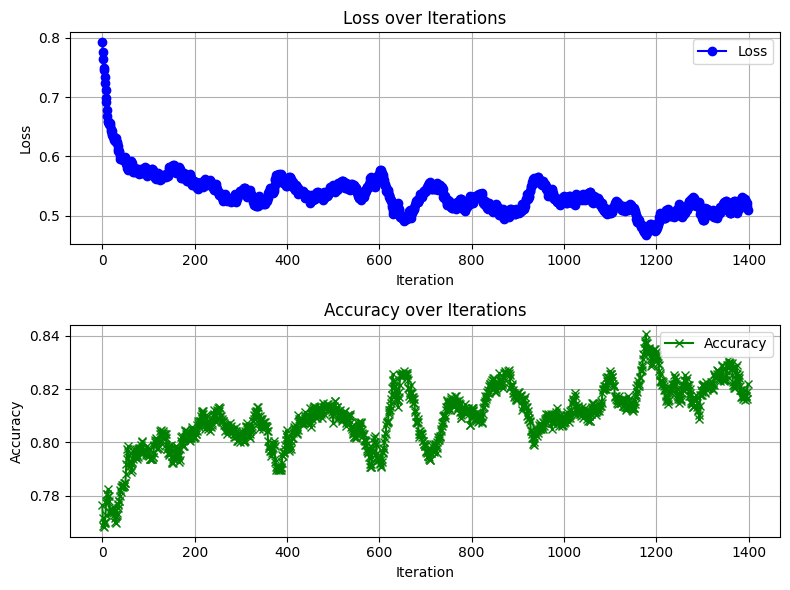

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

smoothedL = movingAverage(losses, window_size)
smoothedA = movingAverage(accuracies, window_size)

# Plot losses on the first subplot
axs[0].plot(smoothedL, marker='o', label='Loss', color='blue')  # 'o' for markers at data points
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over Iterations')
axs[0].legend()  # Show legend with labels
axs[0].grid(True)  # Enable grid

# Plot accuracies on the second subplot
axs[1].plot(smoothedA, marker='x', label='Accuracy', color='green')  # 'x' for different markers
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over Iterations')
axs[1].legend()  # Show legend with labels
axs[1].grid(True)  # Enable grid

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()